# Weather Forecasting

The dataset provided contains daily weather observations for 300 days, including: 
- avg_temperature: Average temperature in °C 
- humidity: Humidity in percentage 
- avg_wind_speed: Average wind speed in km/h 
- rain_or_not: Binary label (1 = rain, 0 = no rain) 
- date: Date of observation 

> Goal: Predict the `rain_or_not` label for future 21 days based on the given features.

## Environment Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [2]:
sns.set_style("darkgrid")
sns.set_palette(sns.husl_palette(h=.5))

## Data Preprocessing and Cleaning

In [3]:
weather_data = pd.read_csv("weather_data.csv")
weather_data.shape

(311, 7)

In [4]:
weather_data.head()

,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
0,2023-01-01,23.745401,46.140905,7.845981,Rain,20.851051,992.965681
1,2023-01-02,30.030503,59.876587,5.382457,Rain,93.059521,1037.273025
2,2023-01-03,28.365224,51.464618,13.158008,Rain,11.636640,1034.193357
3,2023-01-04,27.550929,53.103799,5.886677,Rain,81.744971,968.610142
4,2023-01-05,23.639303,57.826186,12.248992,Rain,38.062329,1030.264331


In [5]:
# Encoding Rain_Or_Not
# Rain = 1 No Rain = 0
weather_data["rain_or_not"] = weather_data["rain_or_not"].replace({"Rain":1, "No Rain": 0})
weather_data.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_10772\788876318.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  weather_data["rain_or_not"] = weather_data["rain_or_not"].replace({"Rain":1, "No Rain": 0})


,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
0,2023-01-01,23.745401,46.140905,7.845981,1,20.851051,992.965681
1,2023-01-02,30.030503,59.876587,5.382457,1,93.059521,1037.273025
2,2023-01-03,28.365224,51.464618,13.158008,1,11.636640,1034.193357
3,2023-01-04,27.550929,53.103799,5.886677,1,81.744971,968.610142
4,2023-01-05,23.639303,57.826186,12.248992,1,38.062329,1030.264331


In [6]:
# Data type 
weather_data["date"] = pd.to_datetime(weather_data["date"])

In [7]:
# Missing Values
weather_data.isna().sum()

date                0
avg_temperature    15
humidity           15
avg_wind_speed     15
rain_or_not         0
cloud_cover        15
pressure            0
dtype: int64

### Missing Value Imputation

Weather data is time series. Neighbourhood sample points (Preceeding and Suceeding points) exhibit similar characteristics.
Hence, Missing values can be imputed through linear interpolation.

In [8]:
weather_data = weather_data.interpolate(method="linear")
weather_data.isna().sum()

date               0
avg_temperature    0
humidity           0
avg_wind_speed     0
rain_or_not        0
cloud_cover        0
pressure           0
dtype: int64

In [9]:
weather_features = ['date', 'avg_temperature', 'humidity', 'avg_wind_speed',
       'cloud_cover', 'pressure', 'rain_or_not']
weather_data = weather_data[weather_features]

## EDA

### Distribution

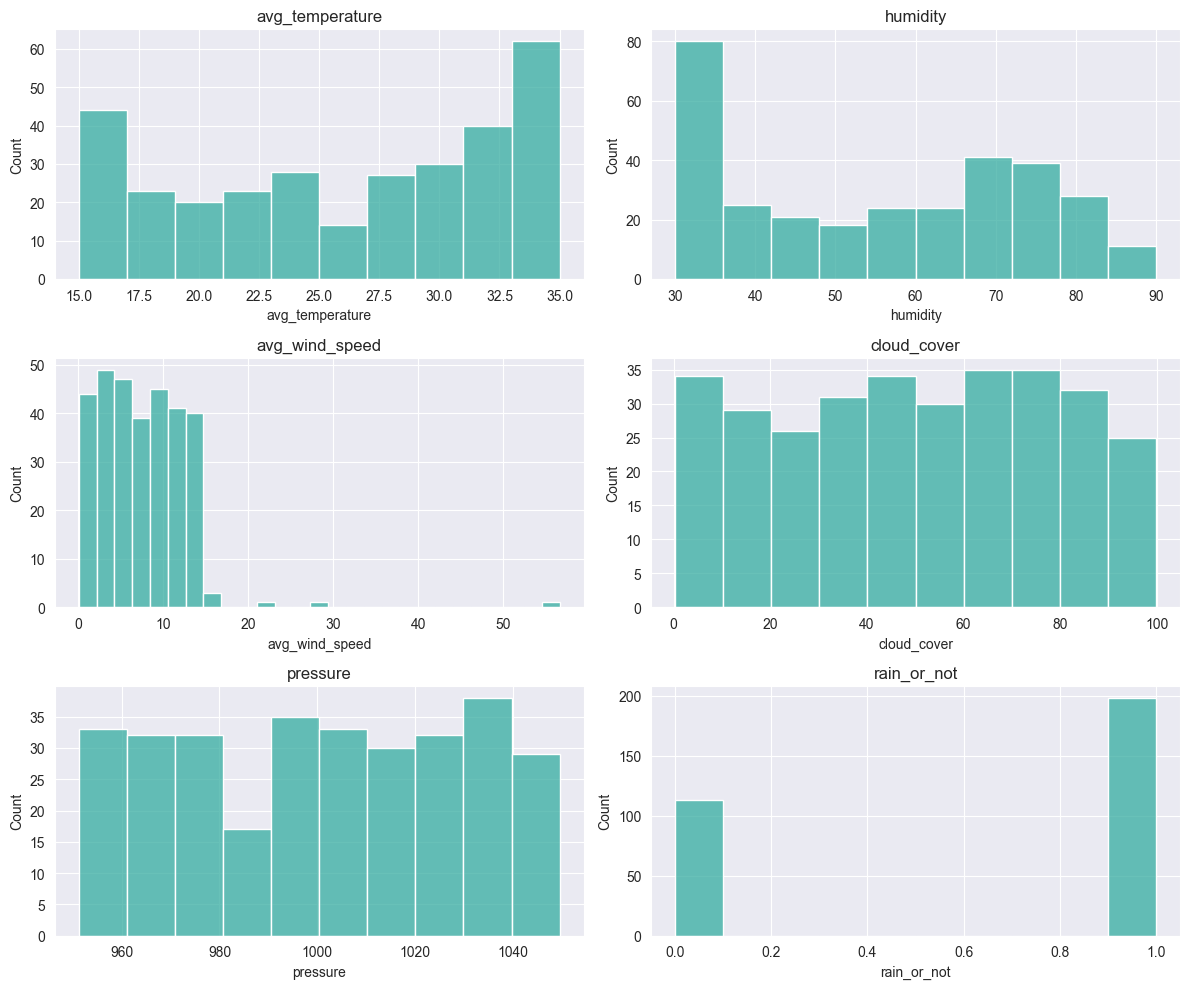

In [10]:
features_of_interest = [ 'avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover',
       'pressure', 'rain_or_not']

fig, axes = plt.subplots(3,2, figsize=(12,10))
axes = axes.flatten()
for i in range(len(features_of_interest)):
    sns.histplot(weather_data[features_of_interest[i]],ax=axes[i])
    axes[i].set_title(features_of_interest[i])

plt.tight_layout()
plt.show()

### Time Series Natue

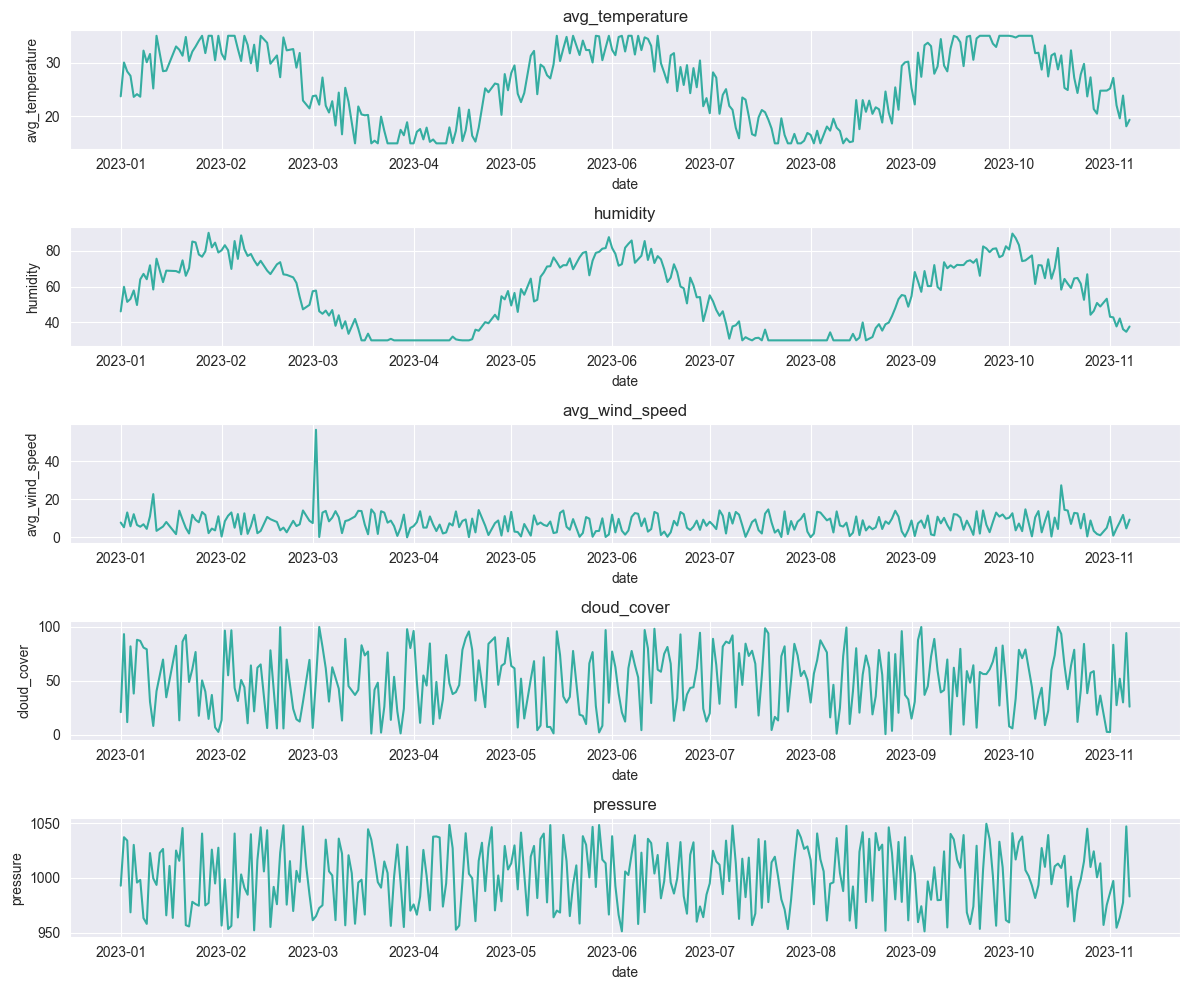

In [11]:
features_of_interest = [ 'avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover',
       'pressure']

fig, axes = plt.subplots(5,1, figsize=(12,10))
axes = axes.flatten()
for i in range(len(features_of_interest)):
    sns.lineplot(x = weather_data["date"],y = weather_data[features_of_interest[i]],ax=axes[i])
    axes[i].set_title(features_of_interest[i])

plt.tight_layout()
plt.show()

#### Correlation Analysis

<Axes: >

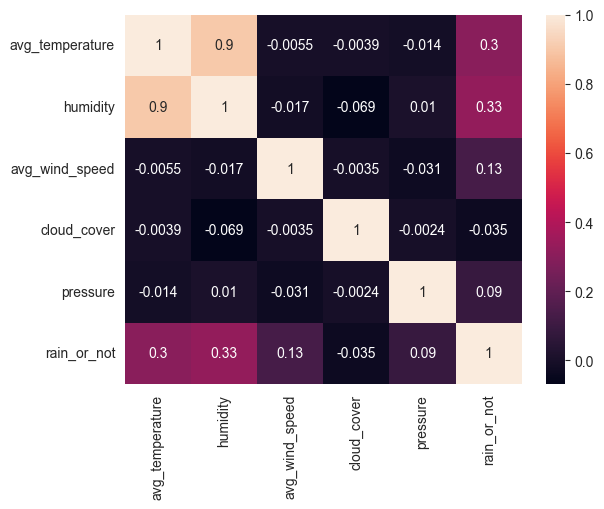

In [12]:
correaltion = weather_data.corr("pearson",numeric_only=True)
sns.heatmap(correaltion, annot=True)

- Humidity and Avg_temperature has strong positive correlation. 
- The following scatter plot confirms the correalation between humidity and avg_temperature.
- Since we aim to choose tree based model for classification, we can leave those features as it is.

<Axes: xlabel='avg_temperature', ylabel='humidity'>

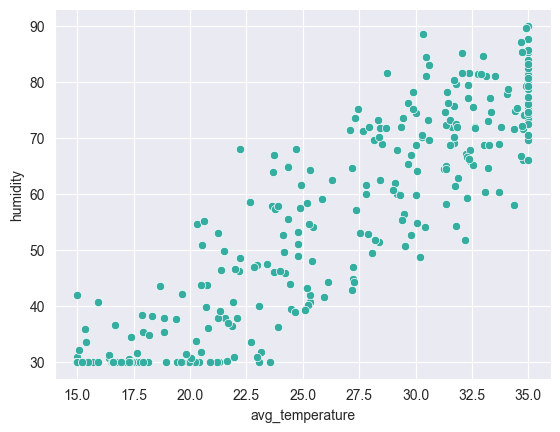

In [13]:
sns.scatterplot(data=weather_data, x = "avg_temperature", y = "humidity")

#### Outlier Analysis

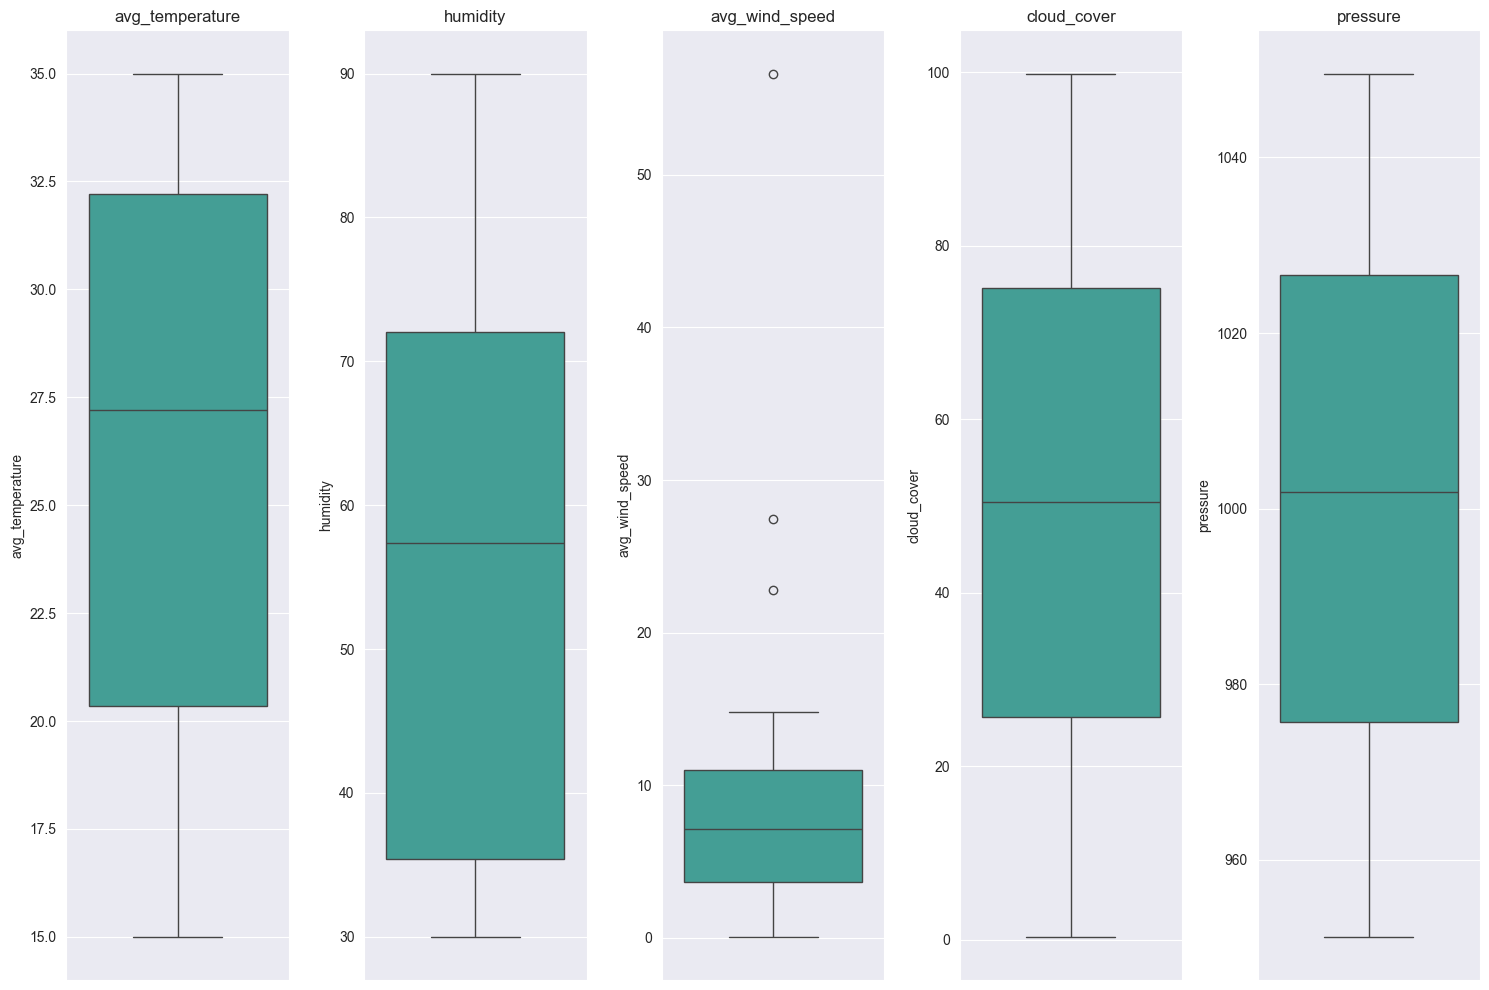

In [14]:
features_of_interest = [ 'avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover',
       'pressure']

fig, axes = plt.subplots(1,5, figsize=(15,10))
axes = axes.flatten()
for i in range(len(features_of_interest)):
    sns.boxplot( weather_data[features_of_interest[i]],ax=axes[i])
    axes[i].set_title(features_of_interest[i])

plt.tight_layout()
plt.show()

##### Outlier Capping

In [15]:
q1 = weather_data["avg_wind_speed"].quantile(0.25)
q3 = weather_data["avg_wind_speed"].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5*iqr
weather_data['avg_wind_speed'] = np.where(weather_data['avg_wind_speed'] > upper_bound, upper_bound, weather_data['avg_wind_speed'])

### Splitting

In [16]:
weather_data['year'] = weather_data['date'].dt.year
weather_data['month'] = weather_data['date'].dt.month
weather_data['day'] = weather_data['date'].dt.day

In [17]:
# Last month as Test Split

train_data = weather_data[weather_data["date"]<"2023.10.18"]
test_data = weather_data[weather_data["date"]>="2023.10.18"]
print("Training Set",train_data.shape)
print("Test Set",test_data.shape)

Training Set (290, 10)
Test Set (21, 10)


In [18]:
train_data.pop("date")
test_data.pop("date")

290   2023-10-18
291   2023-10-19
292   2023-10-20
293   2023-10-21
294   2023-10-22
295   2023-10-23
296   2023-10-24
297   2023-10-25
298   2023-10-26
299   2023-10-27
300   2023-10-28
301   2023-10-29
302   2023-10-30
303   2023-10-31
304   2023-11-01
305   2023-11-02
306   2023-11-03
307   2023-11-04
308   2023-11-05
309   2023-11-06
310   2023-11-07
Name: date, dtype: datetime64[ns]

In [19]:
y_train = train_data.pop("rain_or_not")
X_train = train_data
y_test = test_data.pop("rain_or_not")
X_test = test_data

## Model

### Model 1 - Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from bayes_opt import BayesianOptimization

In [21]:
def objective(n_estimators, max_depth, min_samples_split, max_features):
    model = RandomForestClassifier(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  max_features=min(max_features, 0.999), 
                                  random_state=42)
    
    return -1.0 * cross_val_score(model, X_train, y_train, cv=TimeSeriesSplit(n_splits=3), scoring="neg_log_loss").mean()

In [22]:
param_bounds = {
    'n_estimators': (10, 300),
    'max_depth': (1, 50),
    'min_samples_split': (2, 25),
    'max_features': (0.1, 0.999),
}

In [23]:
optimizer = BayesianOptimization(f=objective, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=20)

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.7058    | 19.35     | 0.9547    | 18.84     | 183.6     |
| 2         | 0.6681    | 8.645     | 0.2402    | 3.336     | 261.2     |
| 3         | 0.7296    | 30.45     | 0.7366    | 2.473     | 291.3     |
| 4         | 0.6806    | 41.79     | 0.2909    | 6.182     | 63.19     |
| 5         | 0.6658    | 15.91     | 0.5718    | 11.93     | 94.46     |
| 6         | 0.728     | 31.27     | 0.7922    | 4.391     | 289.1     |
| 7         | 0.6727    | 49.09     | 0.1999    | 5.696     | 297.2     |
| 8         | 0.707     | 20.46     | 0.6345    | 6.591     | 290.7     |
| 9         | 0.6906    | 36.42     | 0.2957    | 2.061     | 277.5     |
| 10        | 0.6897    | 29.3      | 0.7798    | 11.01     | 295.5     |
| 11        | 0.7417    | 26.55     | 0.7622    | 2.065     | 287.5     |
| 12        | 0.7336    | 21.29     | 

In [24]:
best_params = optimizer.max['params']

In [25]:
best_params

{'max_depth': 48.64104109556947,
 'max_features': 0.9051910604980091,
 'min_samples_split': 2.104441275690838,
 'n_estimators': 15.440158901277412}

In [26]:
final_model = RandomForestClassifier(n_estimators=int(best_params['n_estimators']),
                                   max_depth=int(best_params['max_depth']),
                                   min_samples_split=int(best_params['min_samples_split']),
                                   max_features=best_params['max_features'],
                                   random_state=42)

In [27]:
final_model = final_model.fit(X_train, y_train)

In [28]:
predictions_rf = final_model.predict(X_test)

##### Evaluation

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
class_report = classification_report(y_test,predictions_rf)
print(class_report)

              precision    recall  f1-score   support

           0       0.50      0.80      0.62        10
           1       0.60      0.27      0.38        11

    accuracy                           0.52        21
   macro avg       0.55      0.54      0.50        21
weighted avg       0.55      0.52      0.49        21



Text(45.722222222222214, 0.5, 'True Class')

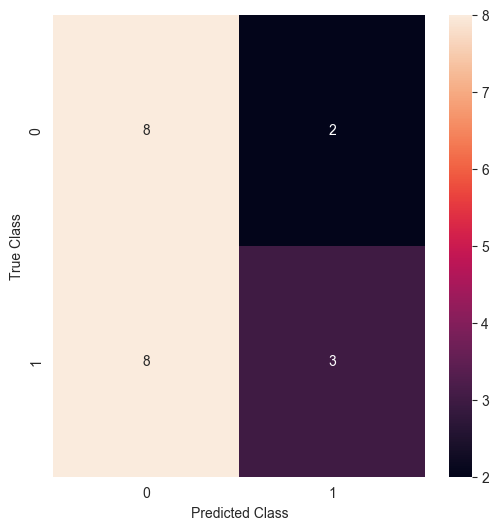

In [31]:
conf_mat = confusion_matrix(y_test,predictions_rf)
plt.figure(figsize=(6,6))
sns.heatmap(conf_mat,annot=True)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

### Model 2 - Decistion tree

In [32]:
### Model 2 - Decistion tree
from sklearn.tree import DecisionTreeClassifier

In [33]:
def objective( max_depth, min_samples_split, max_features):
    model = DecisionTreeClassifier(
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  max_features=min(max_features, 0.999), 
                                  random_state=42)
    
    return -1.0 * cross_val_score(model, X_train, y_train, cv=TimeSeriesSplit(n_splits=3), scoring="neg_log_loss").mean()
param_bounds = {
    'max_depth': (1, 30),
    'min_samples_split': (2, 25),
    'max_features': (0.1, 0.999),
}

In [34]:
optimizer = BayesianOptimization(f=objective, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=20)

|   iter    |  target   | max_depth | max_fe... | min_sa... |
-------------------------------------------------------------
| 1         | 5.816     | 11.86     | 0.9547    | 18.84     |
| 2         | 11.24     | 18.36     | 0.2403    | 5.588     |
| 3         | 1.331     | 2.684     | 0.8787    | 15.83     |
| 4         | 3.261     | 21.53     | 0.1185    | 24.31     |
| 5         | 13.62     | 25.14     | 0.2909    | 6.182     |
| 6         | 16.35     | 29.96     | 0.9491    | 2.061     |
| 7         | 17.02     | 25.79     | 0.4006    | 2.05      |
| 8         | 16.85     | 22.82     | 0.6393    | 2.046     |
| 9         | 16.35     | 24.9      | 0.9912    | 2.49      |
| 10        | 0.6962    | 1.088     | 0.1256    | 2.013     |
| 11        | 17.52     | 24.11     | 0.2108    | 2.041     |
| 12        | 3.919     | 29.95     | 0.1613    | 14.93     |
| 13        | 17.52     | 23.95     | 0.1108    | 2.676     |
| 14        | 0.6962    | 1.171     | 0.2685    | 24.87     |
| 15    

In [35]:
best_params = optimizer.max['params']
best_params

{'max_depth': 13.701090406412115,
 'max_features': 0.9691748843895,
 'min_samples_split': 3.8286197424903703}

In [36]:
final_model = RandomForestClassifier(
                                   max_depth=int(best_params['max_depth']),
                                   min_samples_split=int(best_params['min_samples_split']),
                                   max_features=best_params['max_features'],
                                   random_state=42)

In [37]:
final_model = final_model.fit(X_train, y_train)
predictions_dt = final_model.predict(X_test)

##### Evaluation

In [38]:
class_report = classification_report(y_test,predictions_dt)
print(class_report)

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.55      0.55      0.55        11

    accuracy                           0.52        21
   macro avg       0.52      0.52      0.52        21
weighted avg       0.52      0.52      0.52        21



Text(45.722222222222214, 0.5, 'True Class')

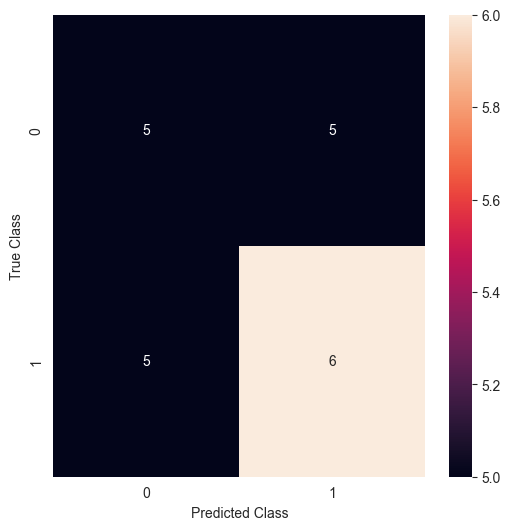

In [39]:
conf_mat = confusion_matrix(y_test,predictions_dt)
plt.figure(figsize=(6,6))
sns.heatmap(conf_mat,annot=True)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

### Model 3 - SVC

In [40]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

In [41]:
svc = SVC()
scaler = MinMaxScaler()

In [42]:
X_train_temp = X_train.copy()
X_test_temp = X_test.copy()
X_train_temp.pop("avg_temperature")
X_test_temp.pop("avg_temperature")
X_train_scaled = scaler.fit_transform(X_train_temp)
X_test_scaled = scaler.transform(X_test_temp)

In [43]:
def objective(C, gamma):
    model = SVC(C = C,
                gamma = gamma,
                probability=True,
                random_state=42)
    
    return -1.0 * cross_val_score(model, X_train_scaled, y_train, cv=TimeSeriesSplit(n_splits=3), scoring="neg_log_loss").mean()
param_bounds = {
    'C': (1e-3, 1e3),  # Regularization parameter
    'gamma': (1e-4, 1e1)  # Kernel coefficient
}

In [44]:
optimizer = BayesianOptimization(f=objective, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=20)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | 0.7322    | 374.5     | 9.507     |
| 2         | 0.7393    | 732.0     | 5.987     |
| 3         | 0.7462    | 156.0     | 1.56      |
| 4         | 0.733     | 58.08     | 8.662     |
| 5         | 0.7358    | 601.1     | 7.081     |
| 6         | 0.8007    | 156.0     | 0.5809    |
| 7         | 0.7552    | 828.4     | 3.003     |
| 8         | 0.8168    | 155.9     | 0.4245    |
| 9         | 0.7996    | 155.7     | 0.6249    |
| 10        | 0.7647    | 154.7     | 0.1307    |
| 11        | 0.7883    | 157.8     | 0.1971    |
| 12        | 0.7514    | 159.2     | 1.292     |
| 13        | 0.7245    | 155.9     | 0.005749  |
| 14        | 0.7445    | 395.1     | 4.874     |
| 15        | 0.8174    | 156.2     | 0.3338    |
| 16        | 0.7524    | 604.1     | 1.517     |
| 17        | 0.7285    | 157.9     | 0.05529   |
| 18        | 0.8069    | 155.8     | 0.5217    |


In [45]:
best_params = optimizer.max['params']
best_params

{'C': 156.2459208273709, 'gamma': 0.33381706331943983}

In [46]:
final_model = SVC(
                C=best_params['C'],
                gamma=best_params['gamma'],
                probability=True,
                random_state=42)

In [47]:
final_model = final_model.fit(X_train_scaled,y_train)
predictions_svc = final_model.predict(X_test_scaled)

##### Evaluation

In [48]:
class_report = classification_report(y_test,predictions_svc)
print(class_report)

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.73      0.73      0.73        11

    accuracy                           0.71        21
   macro avg       0.71      0.71      0.71        21
weighted avg       0.71      0.71      0.71        21



Text(45.722222222222214, 0.5, 'True Class')

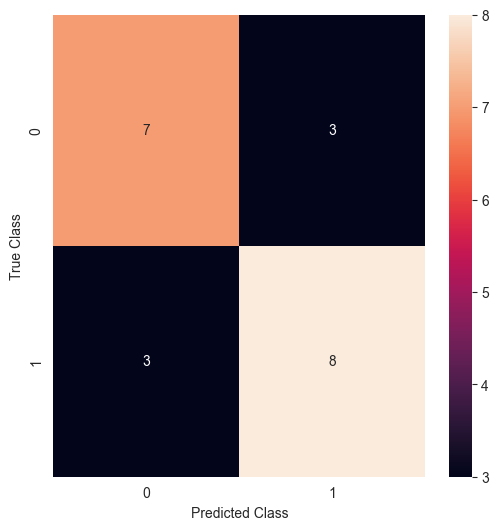

In [49]:
conf_mat = confusion_matrix(y_test,predictions_svc)
plt.figure(figsize=(6,6))
sns.heatmap(conf_mat,annot=True)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")